# Astrometric analysis with ePSF

## Importing some modules

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

/Users/dkawata/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reading a fits file

In [2]:
hdu = pf.open("img_ver1_2_A.fits")[0]
data = hdu.data.astype(np.float32)
norm = simple_norm(data, 'sqrt', percent=99.)

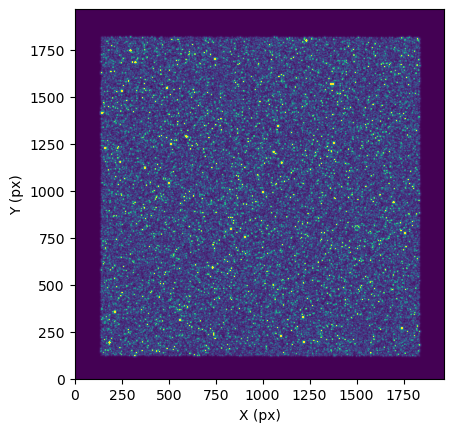

In [3]:
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [4]:
np.shape(data)

(1968, 1968)

### Find Peaks

In [5]:
# Finding peaks.
#    mag = 12.0       # Object magnitude.
mag = 11.0
threshold = 3000.*10.**((mag-12.0)/(-2.5))
peaks_tbl = find_peaks(data, threshold=threshold)

In [6]:
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
   316    125  9666.3301
   322    125  8816.7002
   651    125  7873.3076
   634    128  11776.778
  1720    132  9233.4668
   611    135  11635.645
  1756    137  13934.844
   ...    ...        ...
  1221   1806  7948.9937
  1128   1808  13875.277
  1259   1808  12587.796
  1821   1810  15674.368
  1141   1813  8357.1738
  1221   1813  7625.7861
  1738   1814  15973.133
Length = 1188 rows


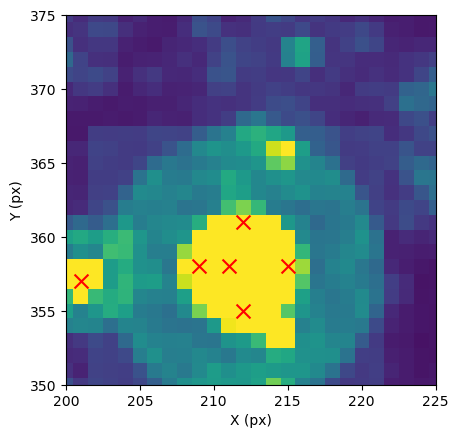

In [7]:
plt.imshow(data, norm=norm,  origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

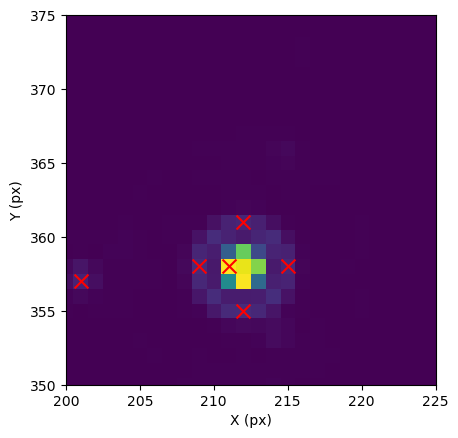

In [8]:
plt.imshow(data, origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

### Read input stellar data

In [9]:
# Loading stellar-plate data.
original = np.loadtxt("galcen_star_plate.csv",skiprows=1,delimiter=",")

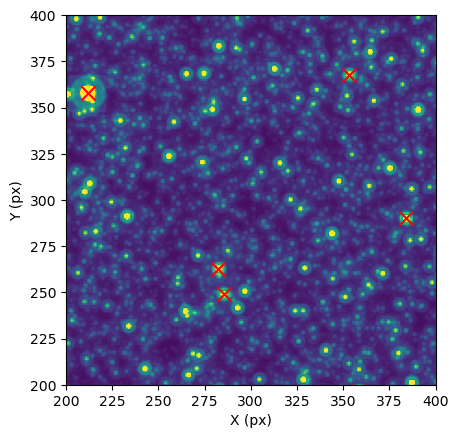

In [10]:
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
maglimit = 12.5
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlim(200, 400)
plt.ylim(200, 400)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [11]:
# Removing detections near edge.
mask_size = 25 
hsize = (mask_size - 1) / 2
x = peaks_tbl['x_peak'] 
y = peaks_tbl['y_peak'] 
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
stars_tbl = Table()
stars_tbl['x'] = x[mask]
stars_tbl['y'] = y[mask]
print(stars_tbl)

 x    y  
---- ----
 316  125
 322  125
 651  125
 634  128
1720  132
 611  135
1756  137
 ...  ...
1221 1806
1128 1808
1259 1808
1821 1810
1141 1813
1221 1813
1738 1814
Length = 1188 rows


Text(0, 0.5, 'Y (px)')

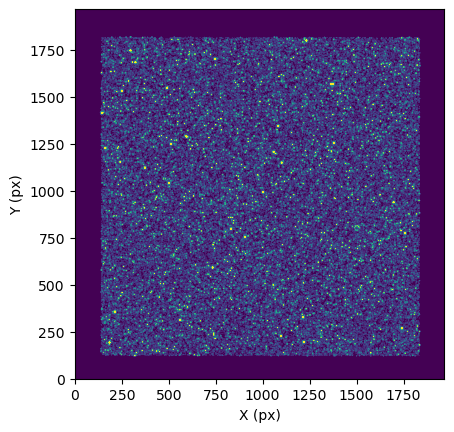

In [12]:
# Subtracting background.
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
image = copy.deepcopy(data)
data -= mean_val
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')

(1968, 1968)


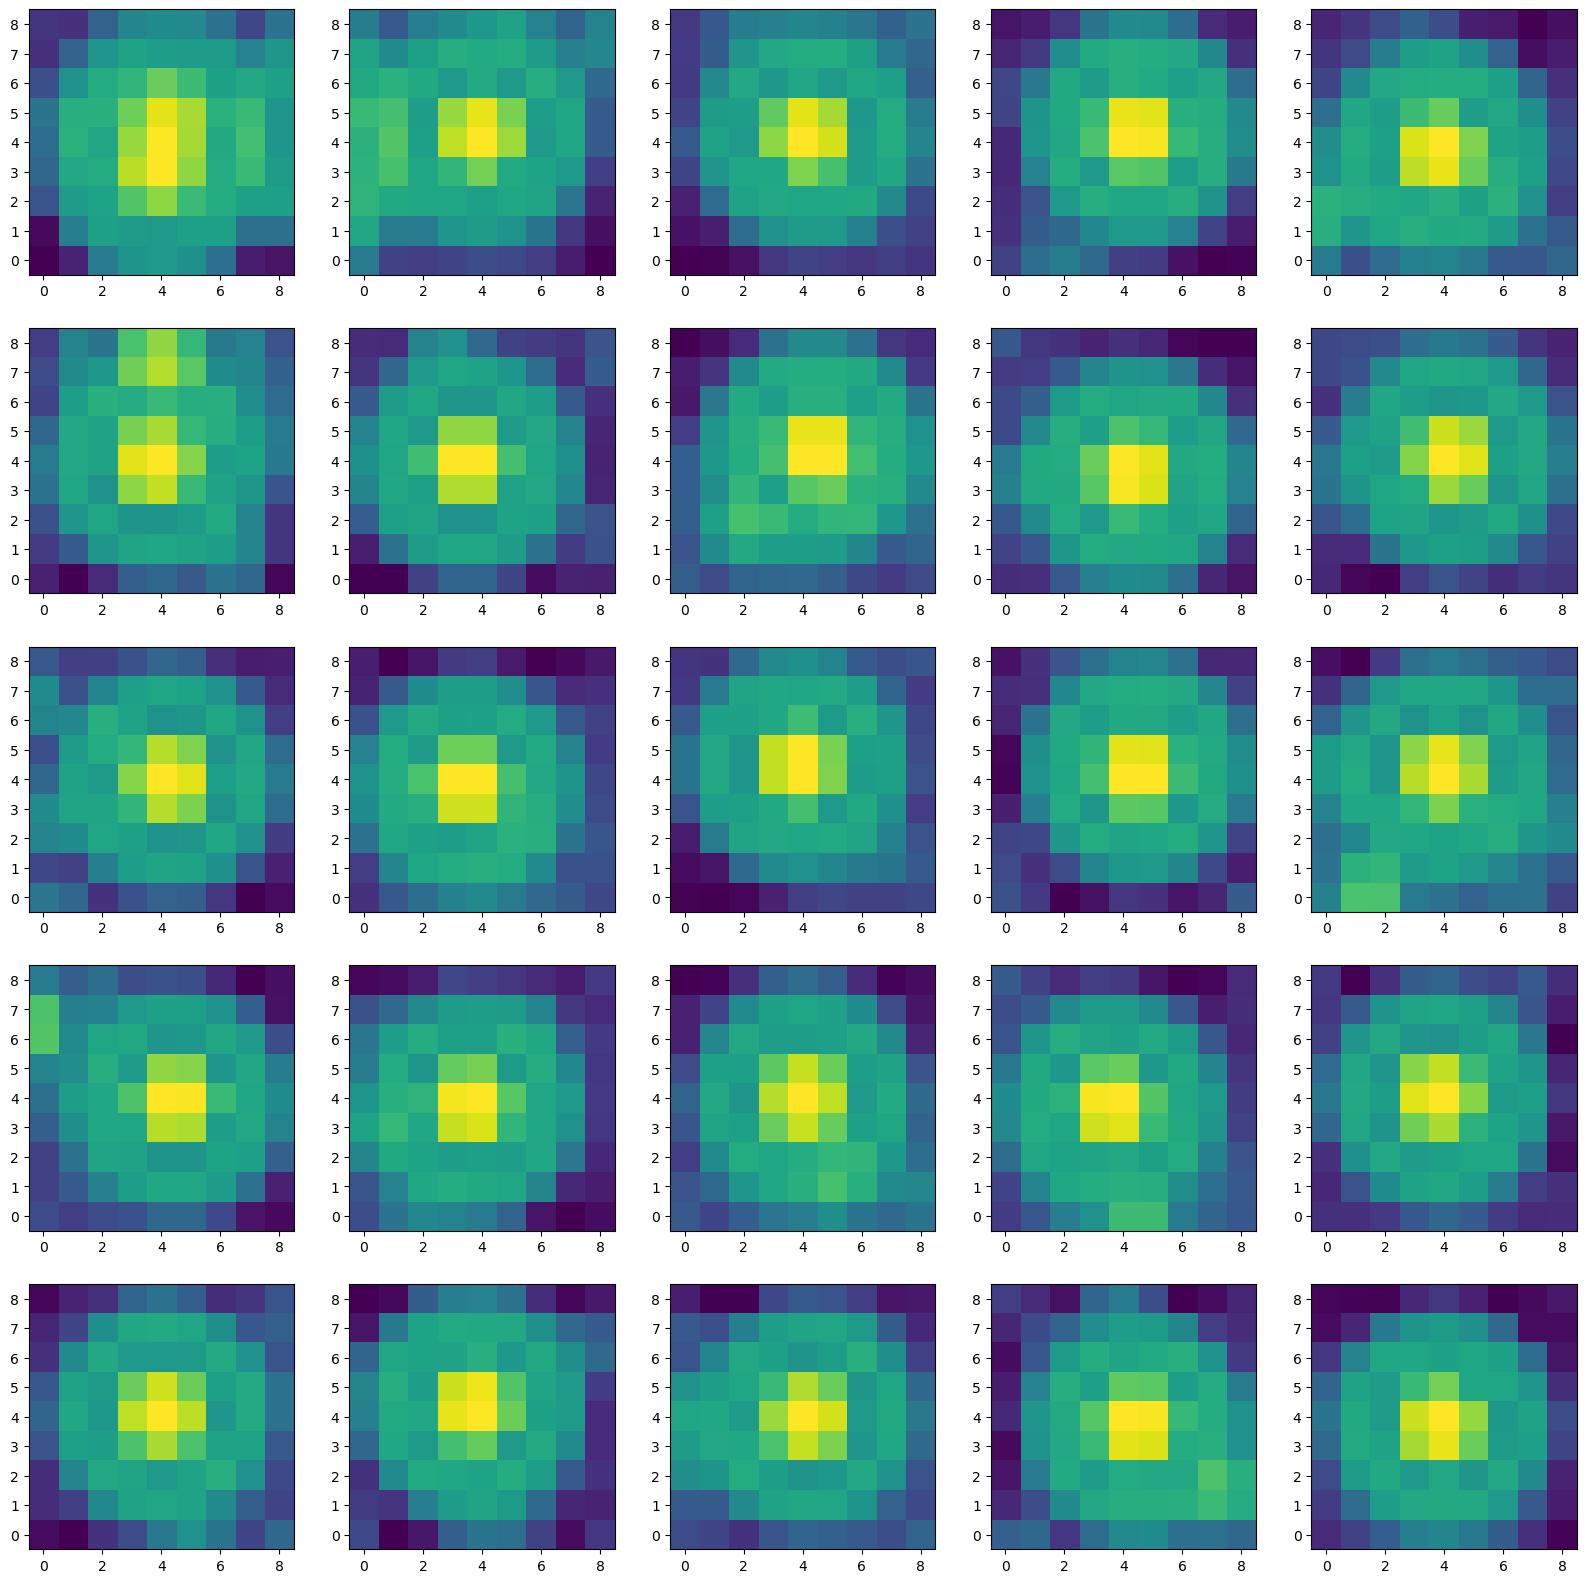

In [13]:
# Extracting stellar images.
ext_size  = 9  
nddata = NDData(data=data)
print(nddata.data.shape)
stars = extract_stars(nddata, stars_tbl, size=ext_size)
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
plt.show()

### Makind ePSF

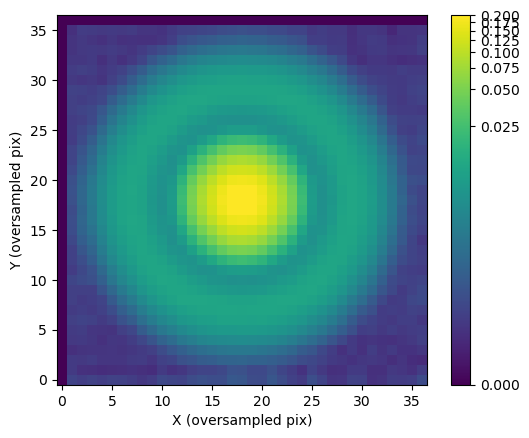

In [14]:
# Making ePSF.
n_oversample = 4 # Number of oversampling for ePSF.
n_maxiter    = 3 # Max. number of iteration for making ePSF.
norm_radius  = 5.5 # Number of undersampled pixels which determines the radius for flux normalization of ePSF.
recentering_boxsize = 5 #  Number of undersampled pixels which determines the box size for ePSF recentering calculation.

epsf_builder = EPSFBuilder(oversampling=n_oversample,
                           maxiters=n_maxiter, progress_bar=False,
                           norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                           center_accuracy=0.001)
epsf, fitted_stars = epsf_builder(stars)
norm = simple_norm(epsf.data, 'log', percent=99.)
    
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()
plt.show()

In [15]:
print(' centre_flat =', fitted_stars.center_flat, np.shape(fitted_stars.center_flat))

 centre_flat = [[ 315.97878165  124.63555269]
 [ 321.91209143  125.31747769]
 [ 651.19396627  125.28241   ]
 ...
 [1140.84226742 1813.34351426]
 [1221.27649009 1812.89638572]
 [1737.69348973 1813.73589551]] (1188, 2)


number of stars brighter than  12.5 = 585


(200.0, 400.0)

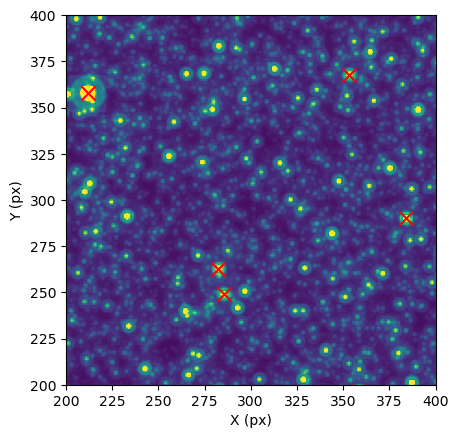

In [16]:
# Subtracting background.
maglimit = 12.5
norm = simple_norm(data, 'sqrt', percent=99.)
print('number of stars brighter than ', maglimit, '=', len(original[original[:,6]<maglimit, 2]))
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim(200, 400)
plt.ylim(200, 400)


Text(0, 0.5, 'Y (px)')

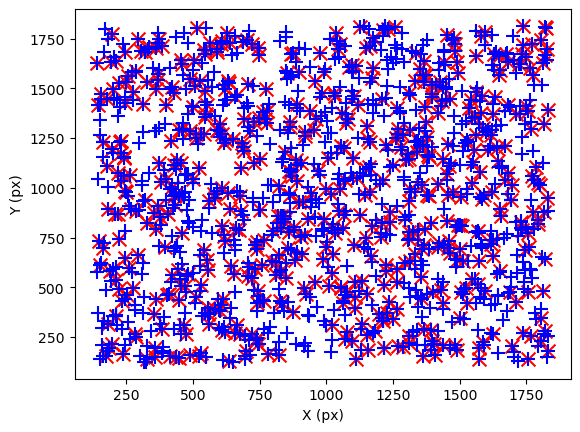

In [17]:
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.scatter(fitted_stars.center_flat[:, 0], fitted_stars.center_flat[:, 1],  s=100, c='blue', marker='+')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
# plt.xlim(200, 300)
# plt.ylim(200, 300)

In [18]:
# Cross-matching the data.
xc_array = []
maglim_o = maglimit+1.0
# search stars only for brighter stars
stars_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_list))

# for loop for fitted stars
nfitted_stars = len(fitted_stars.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars.center_flat), nfitted_stars)
print(' fitted_stars.center_flat', np.shape(fitted_stars.center_flat[0]))
for i in range(nfitted_stars):
    xdiff = fitted_stars.center_flat[i, 0]-stars_list[:, 3]+1.0
    ydiff = fitted_stars.center_flat[i, 1]-stars_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
    # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
    xc_array.append([stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[i, 0],
                             fitted_stars.center_flat[i, 1]])
    if dist2[mindx]>0.6: 
        print(' star ', i, ' min dist =', np.sqrt(dist2[mindx]), stars_list[mindx, 6])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<maglim_o, 3]-1, original[original[:,6]<maglim_o, 2]-1, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(fitted_stars.center_flat[i, 0]-5.0, fitted_stars.center_flat[i, 0]+5.0)
        plt.ylim(fitted_stars.center_flat[i, 1]-5.0, fitted_stars.center_flat[i, 1]+5.0)
        plt.show()
xc_array = np.array(xc_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_array))

(1990, 7)
 N fitted stars= (1188, 2) 1188
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 1188


In [19]:
# excluding bright stars
xc_array = []
maglim_o = maglimit+1.0
maglim_bright = 9.5
# search stars only for brighter stars
stars_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_list))

# for loop for fitted stars
nfitted_stars = len(fitted_stars.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars.center_flat), nfitted_stars)
print(' fitted_stars.center_flat', np.shape(fitted_stars.center_flat[0]))
for i in range(nfitted_stars):
    xdiff = fitted_stars.center_flat[i, 0]-stars_list[:, 3]+1.0
    ydiff = fitted_stars.center_flat[i, 1]-stars_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    if stars_list[mindx, 6]> maglim_bright:
        # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
        # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
        xc_array.append([stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                                 fitted_stars.center_flat[i, 0],
                                 fitted_stars.center_flat[i, 1]])

xc_array = np.array(xc_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_array))

(1990, 7)
 N fitted stars= (1188, 2) 1188
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 1103


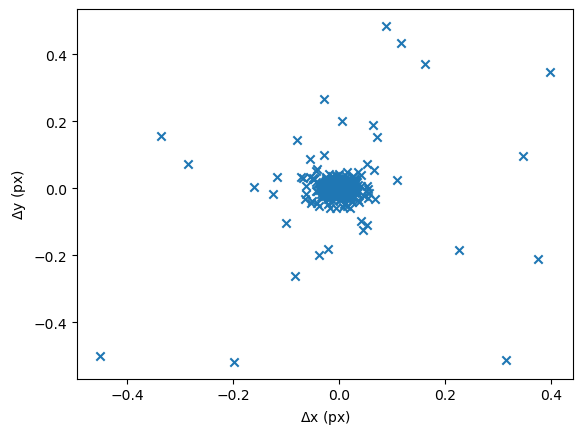

In [20]:
# Making dx/dy data.
dx = xc_array[:,2] - xc_array[:,0]
dy = xc_array[:,3] - xc_array[:,1]
dx = dx - np.mean(dx)
dy = dy - np.mean(dy)
plt.scatter(dx, dy, marker='x')
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')
# plt.xlim([-0.01,0.01])
# plt.ylim([-0.01,0.01])
plt.show()

### Examples of bad cases

The contamination seems to be severe. 

 star  0  dist= 0.49330167684725534


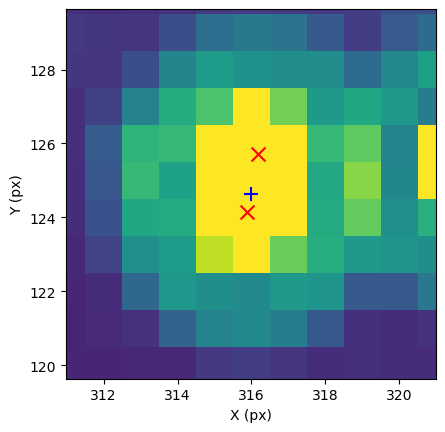

 star  151  dist= 0.4489393201636318


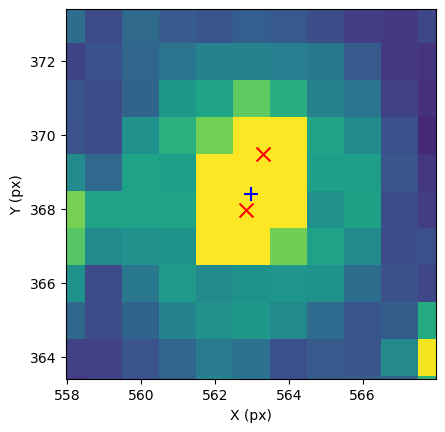

 star  464  dist= 0.5297831215729494


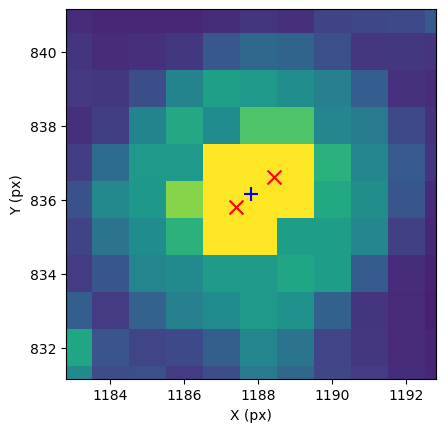

 star  476  dist= 0.4303400950638614


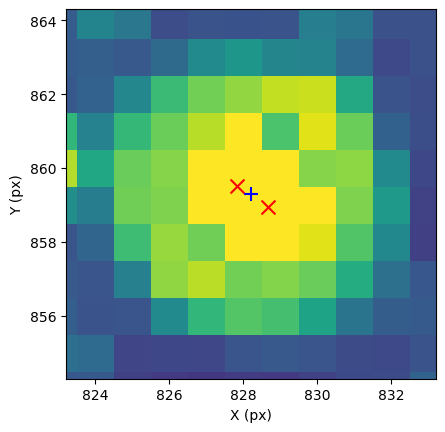

 star  482  dist= 0.3604999762508746


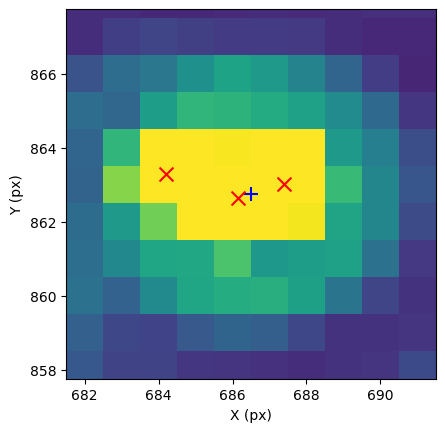

 star  592  dist= 0.673967429101399


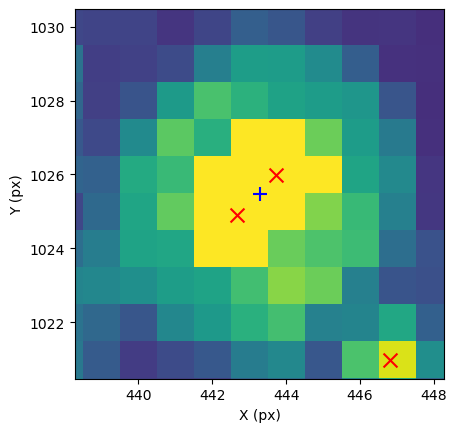

 star  676  dist= 0.6011191402344015


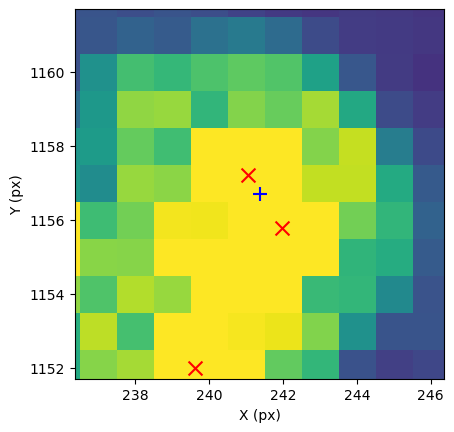

 star  917  dist= 0.3697804015055994


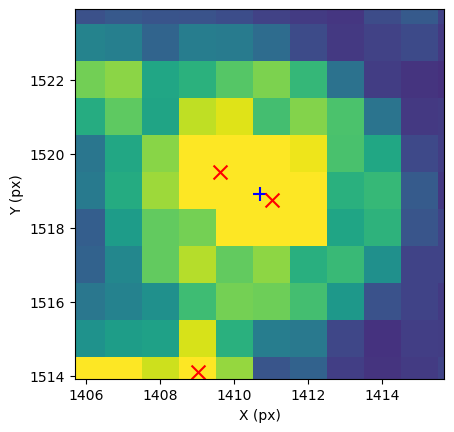

 star  1042  dist= 0.4064913393813608


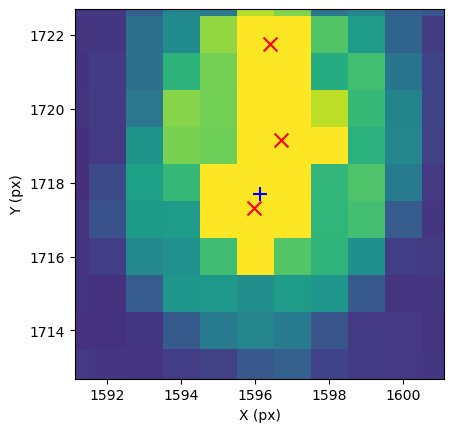

 star  1044  dist= 0.5549521110964931


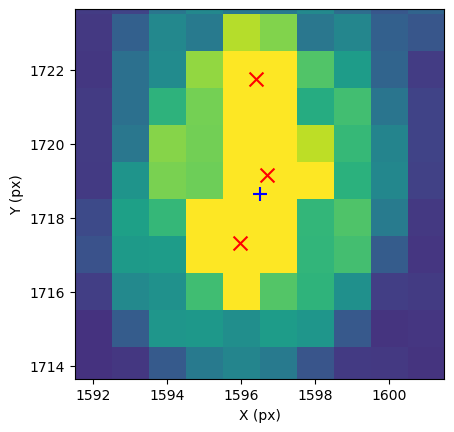

In [21]:
dx = xc_array[:,2] - xc_array[:,0]
dy = xc_array[:,3] - xc_array[:,1]
dx0 = dx - np.mean(dx)
dy0 = dy - np.mean(dy)
dist = np.sqrt(dx0**2+dy0**2)
dx_mean =  np.mean(dx)
dy_mean =  np.mean(dy)
for i in range(len(dist)):
    if dist[i]>0.3: 
        print(' star ', i, ' dist=', dist[i])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(xc_array[i,2], xc_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<15.0, 3]-1+dx_mean, original[original[:,6]<15.0, 2]-1+dy_mean, s=100, c='red', marker='x')
        # plt.scatter(xc_array[i,0]+dx_mean, xc_array[i,1]+dx_mean, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_array[i,2]-5.0, xc_array[i,2]+5.0)
        plt.ylim(xc_array[i,3]-5.0,xc_array[i,3]+5.0)
        plt.show()

### Example of the best cases

Cases with error < 0.003 pix. 

 dx and dy mean =  0.012513683231397326 0.02103764964981971
 N (dist<0.03)= 951
 star  6  dist= 0.0022692482205361264


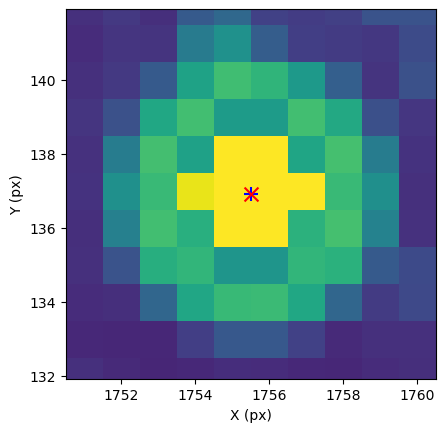

 star  455  dist= 0.002264840340928976


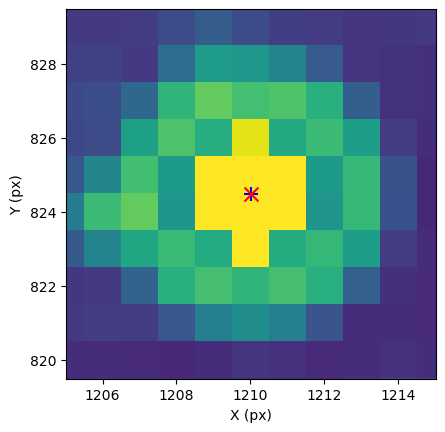

 star  573  dist= 0.002081301659658092


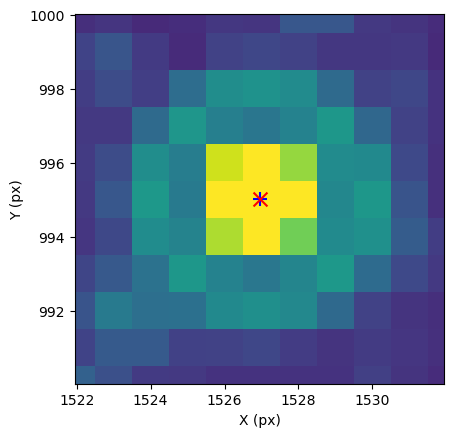

 star  682  dist= 0.0014888197783230668


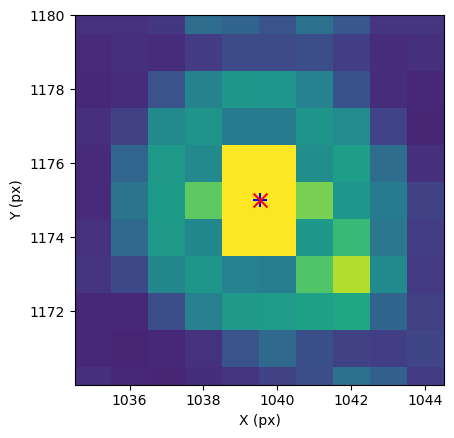

 star  684  dist= 0.0012286848117418318


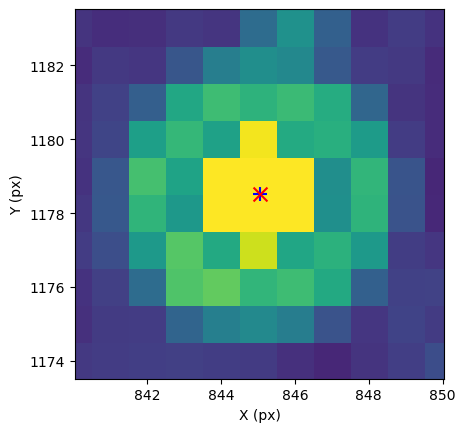

 star  695  dist= 0.0021128800473107223


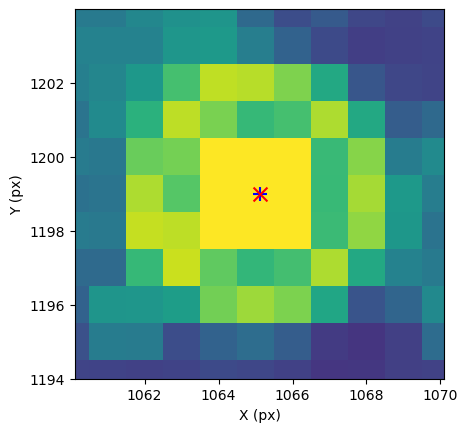

 star  769  dist= 0.0029512576816957156


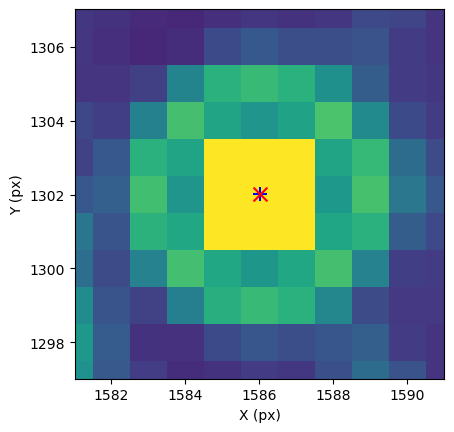

 star  774  dist= 0.00248314519369479


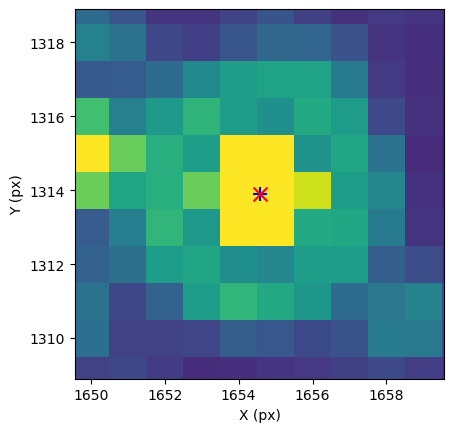

 star  1070  dist= 0.0011572692047000092


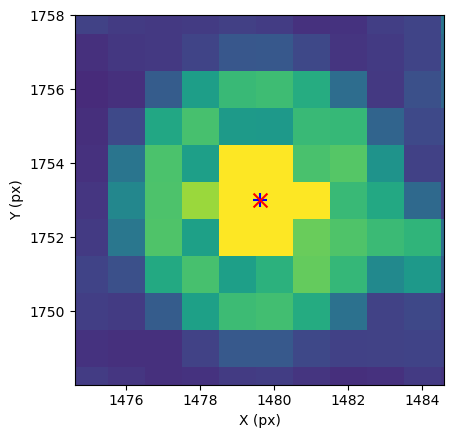

In [22]:
# good ones
print(' dx and dy mean = ', dx_mean, dy_mean)
print(' N (dist<0.03)=', len(dist[dist<0.03]))
for i in range(len(dist)):
    if dist[i]<0.003: 
        print(' star ', i, ' dist=', dist[i])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(xc_array[i,2], xc_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(xc_array[i,0]+dx_mean, xc_array[i,1]+dx_mean, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_array[i,2]-5.0, xc_array[i,2]+5.0)
        plt.ylim(xc_array[i,3]-5.0,xc_array[i,3]+5.0)
        plt.show()

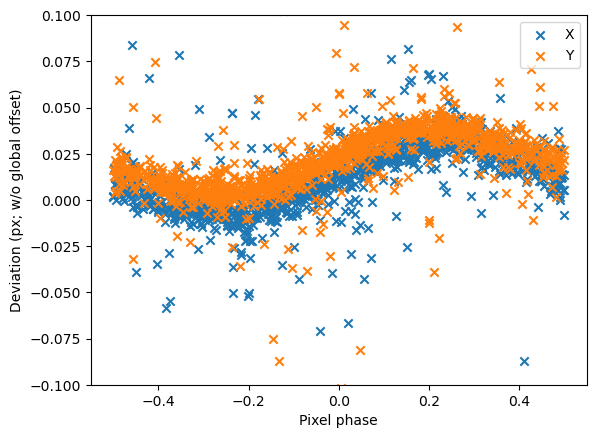

In [23]:
# Making pix-phase error data.
plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
# plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()
    

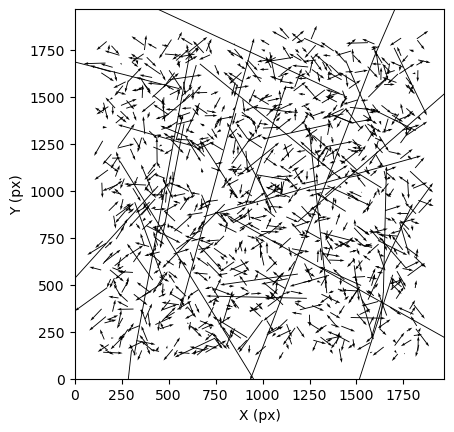

In [24]:
plt.axes().set_aspect('equal')
plt.quiver(xc_array[:,2], xc_array[:,3], dx0, dy0,
               angles='xy', scale_units='xy', scale=0.0003)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim([0, 1968])
plt.ylim([0, 1968])
plt.show()